# Atmospheric composition distribution by CAMS and IASI

### Main goal:
* Compare IASI and CAMS datasets for CO and O<sub>3</sub> (Level 3).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
import datetime # Important for IASI

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_iasi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
component_nom = 'O3'
sensor = 'iasi'
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom)

# Folders generation
generate_folders(model, sensor, component_nom)

The comparison is possible and will start now.


In [5]:
# Define latitudes and longitudes
lat_min = 30
lat_max = 70
lon_min = -25
lon_max = 45

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
print('SEARCH PERIOD')

# IASI
dates_unsorted = ('2020-01', '2020-02', '2020-04', '2021-07', '2021-03')
dates = tuple(sorted(dates_unsorted))
start_date = dates[0]
end_date = dates[-1]
print(f'- In months: {dates}')

SEARCH PERIOD
- In months: ('2020-01', '2020-02', '2020-04', '2021-03', '2021-07')


## 2. Model data

### Download, read and subset data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, 
                                               component_nom, model_full_name, model_level = 'Single')
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds = subset(model_ds, bbox)
model_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (latitude: 54, longitude: 94, time: 3)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2020-01-01 2020-02-01 2020-04-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 30.0 30.75 31.5 32.25 ... 68.25 69.0 69.75
  * longitude   (longitude) float64 -24.75 -24.0 -23.25 ... 43.5 44.25 45.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-08T19:35 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [7]:
model_levels = CAMS_137_levels()
model_levels

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [8]:
model_ds = model_convert_units(model_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg m**-2 to molecules cm**-2.
The model component units have been converted from molecules cm**-2 to dobson.


In [9]:
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 54, longitude: 94, time: 3)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2020-01-01 2020-02-01 2020-04-01
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 30.0 30.75 31.5 32.25 ... 68.25 69.0 69.75
  * longitude   (longitude) float64 -24.75 -24.0 -23.25 ... 43.5 44.25 45.0
    valid_time  (time) datetime64[ns] 2020-01-01 2020-02-01 2020-04-01
Data variables:
    component   (time, latitude, longitude) float32 302.6 302.7 ... 315.1 314.5
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-08T19:35 GRIB to CDM+CF via cfgrib-0.9.9...

## 3. Sensor data

### Collect and read data as xarray

In [10]:
sensor_product_names = []

for date in dates:

    version = IASI_version(component_nom)
    sensor_product_name = IASI_download(component_nom, date, version)
    sensor_product_names.append(sensor_product_name)

IASI_METOPC_L3_O3_COLUMN_202001_ULB-LATMOS_V6.5.1.nc
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1039k  100 1039k    0     0  6882k      0 --:--:-- --:--:-- --:--:-- 6882k
IASI_METOPC_L3_O3_COLUMN_202002_ULB-LATMOS_V6.5.1.nc
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1039k  100 1039k    0     0  6882k      0 --:--:-- --:--:-- --:--:-- 6882k
IASI_METOPC_L3_O3_COLUMN_202004_ULB-LATMOS_V6.5.1.nc
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1039k  100 1039k    0     0  6376k      0 --:--:-- --:--:-- --:--:-- 6337k


In [11]:
sensor_ds, sensor_type = IASI_read(sensor_product_names, component_nom)
sensor_ds

<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 3)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-01 2020-02-01 2020-04-01
  * latitude        (latitude) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * longitude       (longitude) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    O3gridDAY       (time, latitude, longitude) float32 0.1429 0.151 ... 0.1461
    O3gridNIGHT     (time, latitude, longitude) float32 nan nan nan ... nan nan
    ErrorgridDAY    (time, latitude, longitude) float32 0.003853 ... 0.002294
    ErrorgridNIGHT  (time, latitude, longitude) float32 nan nan nan ... nan nan
Attributes: (12/34)
    title:                                   IASI/Metop-C ULB-LATMOS ozone (O...
    institution:                             AERIS
    product_version:                         6.5.1
    history:                                 2020-11-20 00:08:19 - Product ge...
    summary:                                 This dataset contains Level 3 oz...
    source:                                  EUMETSAT IASI Level 2 ozone (O3)...
    ...                                      ...
    sensor:                                  IASI
    spatial_resolution:                      grid: 1 deg x 1 deg
    creator_name:                            AERIS
    creator_type:                            institution
    contact_email:                           contact form at http://iasi.aeri...
    data_policy:                             see https://iasi.aeris-data.fr/d...

### Convert IASI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [12]:
sensor_ds = sensor_convert_units(sensor_ds, sensor_column, sensor, component)
sensor_ds

The sensor component units have been converted from mol m**-2 to molecules cm**-2.
The sensor component units have been converted from molecules cm**-2 to dobson.


<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 3)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-01 2020-02-01 2020-04-01
  * latitude        (latitude) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * longitude       (longitude) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    O3gridDAY       (time, latitude, longitude) float64 320.0 338.0 ... 327.1
    O3gridNIGHT     (time, latitude, longitude) float64 nan nan nan ... nan nan
    ErrorgridDAY    (time, latitude, longitude) float64 8.625 5.184 ... 5.135
    ErrorgridNIGHT  (time, latitude, longitude) float64 nan nan nan ... nan nan
Attributes: (12/34)
    title:                                   IASI/Metop-C ULB-LATMOS ozone (O...
    institution:                             AERIS
    product_version:                         6.5.1
    history:                                 2020-11-20 00:08:19 - Product ge...
    summary:                                 This dataset contains Level 3 oz...
    source:                                  EUMETSAT IASI Level 2 ozone (O3)...
    ...                                      ...
    sensor:                                  IASI
    spatial_resolution:                      grid: 1 deg x 1 deg
    creator_name:                            AERIS
    creator_type:                            institution
    contact_email:                           contact form at http://iasi.aeri...
    data_policy:                             see https://iasi.aeris-data.fr/d...

## 4. Match data (and apply averaging kernels)

In [13]:
kernels_method = None
match_table = generate_match_table(sensor_ds, model_ds, bbox, sensor_product_name, kernels_method)
match_table

FOR 2020-01-01T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR 2020-02-01T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR 2020-04-01T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.


,latitude,longitude,time,O3gridDAY,O3gridNIGHT,ErrorgridDAY,ErrorgridNIGHT,model_column
0,29.5,-25.5,2020-01-01,299.284804,290.400144,0.452052,0.463988,302.583099
1,29.5,-24.5,2020-01-01,297.109367,290.490260,0.437754,0.425563,302.583099
2,29.5,-23.5,2020-01-01,296.316537,292.643739,0.455010,0.559435,302.877930
3,29.5,-22.5,2020-01-01,292.732038,292.066260,0.403175,0.442537,303.155457
4,29.5,-21.5,2020-01-01,299.042375,292.812847,0.550015,0.475995,303.387970
...,...,...,...,...,...,...,...,...
2906,69.5,40.5,2020-04-01,310.823753,303.578332,0.599510,1.083632,317.337036
2907,69.5,41.5,2020-04-01,295.345291,279.479643,0.514036,1.472962,316.930939
2908,69.5,42.5,2020-04-01,300.226070,299.480879,0.509135,0.936620,316.099701
2909,69.5,43.5,2020-04-01,281.017686,280.144933,0.492791,3.762212,315.620148


## 5. Merge data and calculate difference

In [14]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, kernels_method)
merge_table

O3gridDAY  O3gridNIGHT  ErrorgridDAY  \
latitude longitude time                                                
29.5     -25.5     2020-01-01  299.284804   290.400144      0.452052   
                   2020-02-01  284.994557   289.166129      0.580096   
                   2020-04-01  318.989479   312.435117      0.527591   
         -24.5     2020-01-01  297.109367   290.490260      0.437754   
                   2020-02-01  285.377822   291.133747      0.548859   
...                                   ...          ...           ...   
69.5      43.5     2020-02-01  324.205439   290.897743      1.867020   
                   2020-04-01  281.017686   280.144933      0.492791   
          44.5     2020-01-01  262.838026   287.308236      2.437309   
                   2020-02-01  309.013656   306.368118      1.074527   
                   2020-04-01  289.755484   288.092381      0.464332   

                               ErrorgridNIGHT  model_column  difference  
latitude longitude time                                                  
29.5     -25.5     2020-01-01        0.463988    302.583099   -3.298296  
                   2020-02-01        0.517245    298.177032  -13.182475  
                   2020-04-01        0.451764    328.796265   -9.806786  
         -24.5     2020-01-01        0.425563    302.583099   -5.473732  
                   2020-02-01        0.534004    298.177032  -12.799211  
...                                       ...           ...         ...  
69.5      43.5     2020-02-01        1.476751    320.310425    3.895015  
                   2020-04-01        3.762212    315.620148  -34.602461  
          44.5     2020-01-01        1.239178    315.442291  -52.604265  
                   2020-02-01        0.916566    320.219330  -11.205674  
                   2020-04-01        1.179977    315.053619  -25.298136  

[8733 rows x 6 columns]

## 6. Show comparison plots

### Select plot dates

In [15]:
plot_dates = plot_period(sensor_ds)

The plots will be shown for the following dates:
['2020-01' '2020-02' '2020-04']


### Select plot extent

In [16]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-25, 30), (45, 70))


### Compare CAMS and IASI total columns

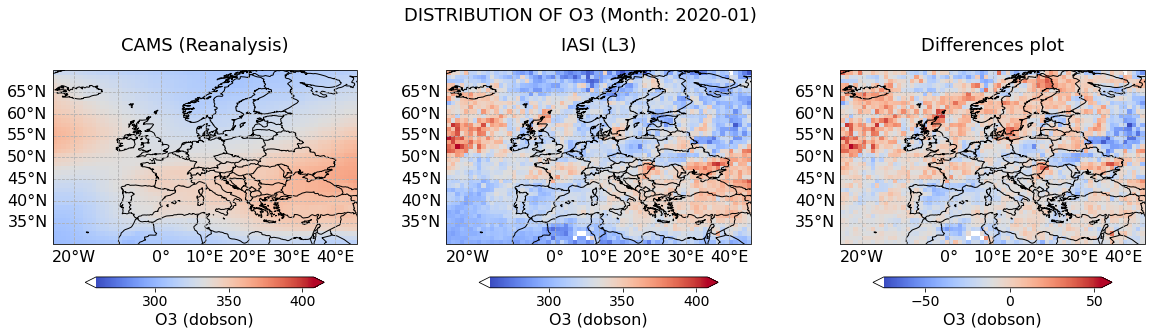

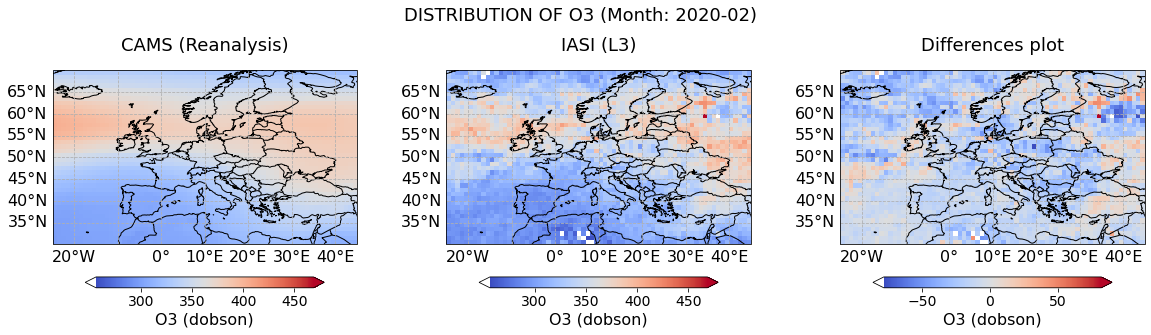

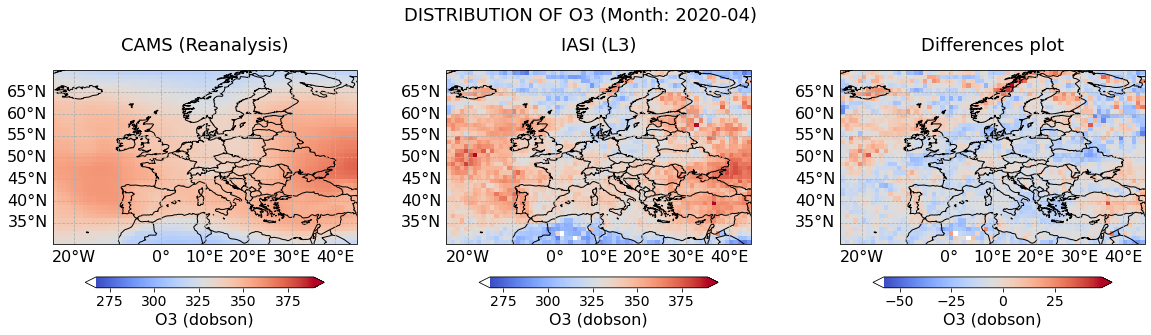

In [17]:
range_type = 'Equal' # Original, Positive, Equal
visualize_model_vs_sensor(model, sensor, component_nom, model_ds, merge_table, plot_dates, 
                          plot_bbox, 20, 1.10, model_type, sensor_type, range_type)

## 7. Scatter plots

Month: 2020-01
Fit equation: Model O3 = Sensor O3 * 0.46 + (1.83E+02)
Coefficient of determination (R2): 0.45


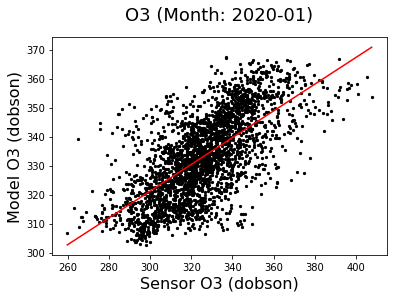

Month: 2020-02
Fit equation: Model O3 = Sensor O3 * 0.80 + (7.95E+01)
Coefficient of determination (R2): 0.75


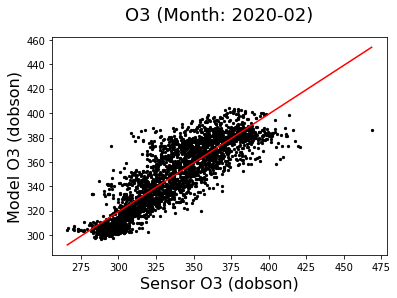

Month: 2020-04
Fit equation: Model O3 = Sensor O3 * 0.58 + (1.47E+02)
Coefficient of determination (R2): 0.58


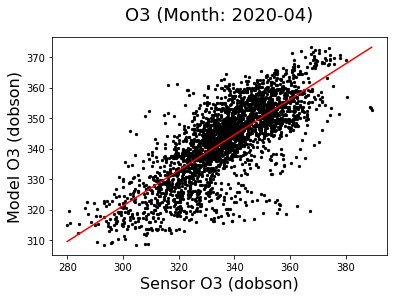

In [18]:
scatter_plot(merge_table.dropna(), component_nom, model_ds, plot_dates, plot_bbox, 1.05)